In [3]:
import os
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


tf.random.set_seed(42)  # For reproducibility

In [4]:
class DataProcessor:
    def __init__(self, base_path):
        self.base_path = base_path
        self.image_size = (360, 360)
        self.label_encoder = None
    
    def load_and_preprocess_image(self, filename, label, bbox):
        try:
            img = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, self.image_size)
            img = tf.cast(img, tf.float32) / 255.0
            
            # Add data augmentation for training
            if tf.random.uniform([]) > 0.5:
                img = tf.image.random_brightness(img, 0.2)
                img = tf.image.random_contrast(img, 0.8, 1.2)
                img = tf.image.random_saturation(img, 0.8, 1.2)
                img = tf.image.random_hue(img, 0.1)  
                
            return img, label, bbox
        except tf.errors.NotFoundError:
            tf.print(f"File not found: {filename}")
            return None, None, None

    def create_dataset(self, csv_file, base_dir, is_training=True, batch_size=16):
        df = pd.read_csv(csv_file)
        
        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            df['class'] = self.label_encoder.fit_transform(df['class'])
        else:
            df['class'] = self.label_encoder.transform(df['class'])

        filenames = df['filename'].apply(lambda x: os.path.join(base_dir, x)).values
        labels = df['class'].values
        labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_encoder.classes_))
        bboxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.float32)
        
        # Normalize bounding box coordinates
        bboxes = bboxes / np.array([self.image_size[1], self.image_size[0], self.image_size[1], self.image_size[0]])

        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels_one_hot, bboxes))
        dataset = dataset.map(
            lambda f, l, b: (self.load_and_preprocess_image(f, l, b)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.filter(lambda x, y, z: x is not None)
        
        def prepare_data(img, label, bbox):
            return img, {'class_output': label, 'bbox_output': bbox}
            
        dataset = dataset.map(prepare_data)
        
        if is_training:
            dataset = dataset.shuffle(buffer_size=1000)
            
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        
        return dataset


In [5]:

class VisionModel:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = Input(shape=(360, 360, 3))
        
        # Base model with custom initialization
        base_model = base_model = VGG16(weights='imagenet', include_top=False, input_shape=(360, 360, 3))
        for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
            layer.trainable = False

        # Custom initialization for convolution layers
        for layer in base_model.layers:
            if isinstance(layer, Conv2D):
                layer.kernel_initializer = tf.keras.initializers.HeNormal()
        
        x = base_model(inputs, training=True)
        
        # Custom feature extraction blocks
        def conv_block(x, filters):
            x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            return x
            
        x = conv_block(x, 64)
        x = conv_block(x, 128)
        
        x = GlobalAveragePooling2D()(x)
        
        # Fully connected layers with residual connections
        def fc_block(x, units, dropout_rate=0.5):
            skip = x
            x = Dense(units)(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = Dropout(dropout_rate)(x)
            if skip.shape[-1] == units:
                x = x + skip
            return x
            
        x = fc_block(x, 512)
        x = fc_block(x, 256)
        x = fc_block(x, 128)
        x = fc_block(x, 64)
        
        # Output layers
        class_output = Dense(self.num_classes, activation='softmax', name='class_output')(x)
        bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)  # Using sigmoid for normalized coordinates
        
        model = Model(inputs=inputs, outputs=[class_output, bbox_output])
        return model
        
    def compile_model(self, learning_rate=0.0001):
        optimizer = AdamW(
            learning_rate=learning_rate,
            weight_decay=0.0001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss={
                'class_output': 'categorical_crossentropy',
                'bbox_output': 'huber'  # Using huber loss for better bbox regression
            },
            loss_weights={'class_output': 1.0, 'bbox_output': 1.0},
            metrics={
                'class_output': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)],
                'bbox_output': ['mae', tf.keras.metrics.MeanSquaredError()]
            }
        )
    
    def get_callbacks(self, model_dir='model'):
        callbacks = [
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                os.path.join(model_dir, 'model-{epoch:02d}-{val_loss:.2f}.keras'),
                monitor='val_loss',
                save_best_only=True,
                verbose=1,
                save_weights_only=False
            )
        ]
        return callbacks


In [6]:
def plot_metrics(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()


In [7]:

def train_model():
    base_path = 'dataset/'
    data_processor = DataProcessor(base_path)
    
    # Create datasets
    train_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'train', '_annotations.csv'),
        os.path.join(base_path, 'train'),
        is_training=True
    )
    
    valid_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'valid', '_annotations.csv'),
        os.path.join(base_path, 'valid'),
        is_training=False
    )
    
    # Initialize and train model
    model = VisionModel(num_classes=len(data_processor.label_encoder.classes_))
    model.compile_model()
    
    # Train the model
    history = model.model.fit(
        train_dataset,
        epochs=100,
        validation_data=valid_dataset,
        callbacks=model.get_callbacks(),
        workers=4,
        use_multiprocessing=True
    )
    
    model_save_path = 'model/my_model.h5'
    model.model.save(model_save_path)  # Saves the model in TensorFlow's SavedModel format
    print(f'Model saved to: {model_save_path}')
    plot_metrics(history)
    return model, history, data_processor


58889256/58889256 [==============================] - 19s 0us/step
Epoch 1/100
    200/Unknown - 842s 4s/step - loss: 1.9038 - class_output_loss: 1.8411 - bbox_output_loss: 0.0627 - class_output_accuracy: 0.2537 - class_output_top_k_categorical_accuracy: 0.5178 - bbox_output_mae: 0.2861 - bbox_output_mean_squared_error: 0.1254
Epoch 1: val_loss improved from inf to 1.56072, saving model to model\model-01-1.56.keras
200/200 [==============================] - 1011s 5s/step - loss: 1.9038 - class_output_loss: 1.8411 - bbox_output_loss: 0.0627 - class_output_accuracy: 0.2537 - class_output_top_k_categorical_accuracy: 0.5178 - bbox_output_mae: 0.2861 - bbox_output_mean_squared_error: 0.1254 - val_loss: 1.5607 - val_class_output_loss: 1.4699 - val_bbox_output_loss: 0.0908 - val_class_output_accuracy: 0.2295 - val_class_output_top_k_categorical_accuracy: 0.4982 - val_bbox_output_mae: 0.3632 - val_bbox_output_mean_squared_error: 0.1816 - lr: 1.0000e-04
Epoch 2/100
200/200 [=====================

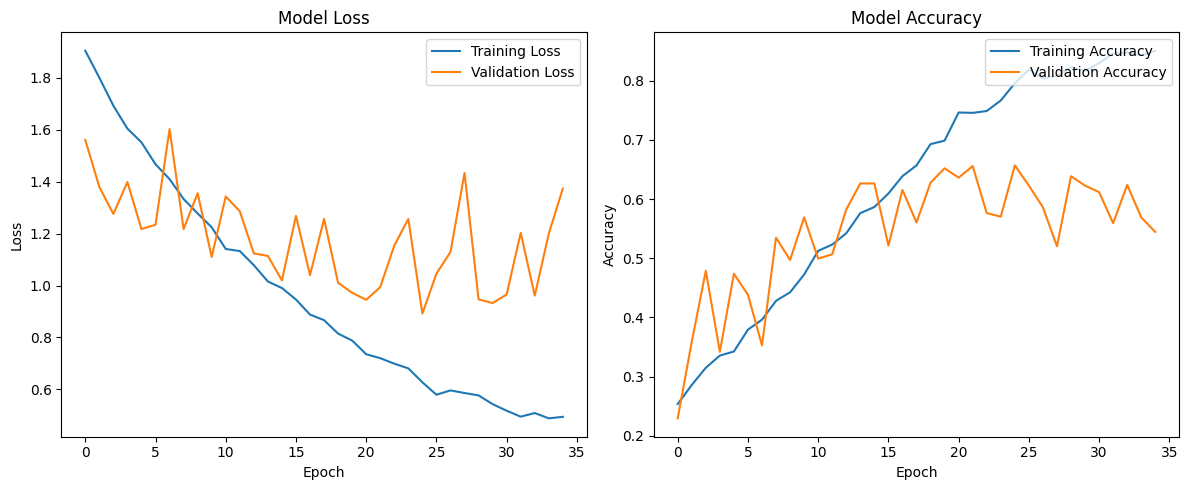

In [6]:
model, history, data_processor = train_model()

In [7]:

test_dataset = data_processor.create_dataset(
        os.path.join('dataset', 'test', '_annotations.csv'),
        os.path.join('dataset', 'test'),
        is_training=False
    )

    # Predictions on test data
class_pred, bbox_pred = model.model.predict(test_dataset)
class_pred_labels = np.argmax(class_pred, axis=1)

    # Extract true class labels from test dataset
true_class_labels = []
for images, labels in test_dataset.unbatch():
    true_class_labels.append(np.argmax(labels['class_output']))

true_class_labels = np.array(true_class_labels)

    # Classification report
print("Classification Report:")
print(classification_report(true_class_labels, class_pred_labels, target_names=data_processor.label_encoder.classes_))

  

30/30 [==============================] - 89s 3s/step
Classification Report:
              precision    recall  f1-score   support

     HandGun       0.65      0.76      0.70       143
       Rifle       0.62      0.86      0.72       150
         SMG       0.76      0.41      0.53        83
     ShotGun       0.73      0.38      0.50        91

    accuracy                           0.66       467
   macro avg       0.69      0.60      0.61       467
weighted avg       0.68      0.66      0.64       467



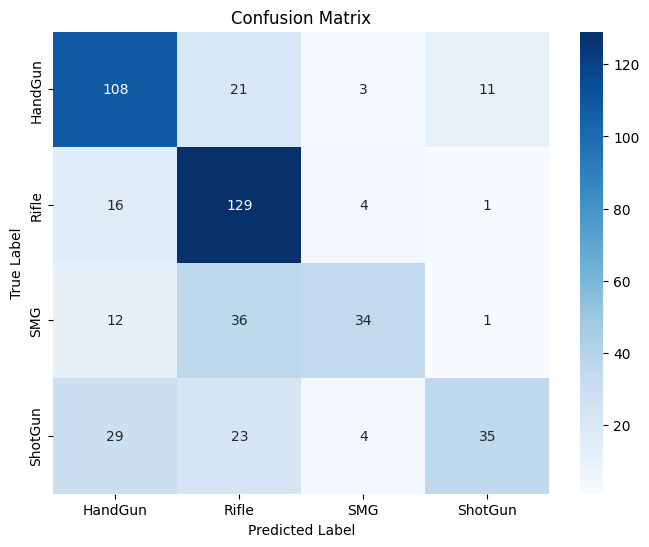

In [8]:
  # Confusion Matrix
conf_matrix = confusion_matrix(true_class_labels, class_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data_processor.label_encoder.classes_, yticklabels=data_processor.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [1]:
from tensorflow.keras.models import load_model
model = load_model('model/my_model.h5')

In [27]:
# Evaluate the model
results = model.evaluate(test_dataset)

# Unpack the results
test_loss, class_output_loss, bbox_output_loss, test_accuracy, top_k_categorical_accuracy, bbox_output_mae, bbox_output_mean_squared_error = results

# Print the relevant metrics
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')
print(f'Bounding Box MAE: {bbox_output_mae}, Bounding Box MSE: {bbox_output_mean_squared_error}')
print(f'Top-k Categorical Accuracy: {top_k_categorical_accuracy}')


30/30 [==============================] - 113s 4s/step - loss: 0.9622 - class_output_loss: 0.9363 - bbox_output_loss: 0.0259 - class_output_accuracy: 0.6552 - class_output_top_k_categorical_accuracy: 0.8501 - bbox_output_mae: 0.1903 - bbox_output_mean_squared_error: 0.0517
Test Accuracy: 0.6552462577819824, Test Loss: 0.9621806740760803
Bounding Box MAE: 0.19034096598625183, Bounding Box MSE: 0.05173724889755249
Top-k Categorical Accuracy: 0.8501070737838745


In [9]:
base_path = 'dataset/'
data_processor = DataProcessor(base_path)
test_dataset = data_processor.create_dataset(
    os.path.join(base_path, 'test', '_annotations.csv'),
    os.path.join(base_path, 'test'),
    is_training=False
)

y_pred = model.predict(test_dataset)
print(y_pred)

30/30 [==============================] - 94s 3s/step


NameError: name 'test_labels' is not defined

[array([[0.32152107, 0.34609163, 0.2149484 , 0.11743885],
       [0.00819523, 0.7565565 , 0.02173813, 0.21351004],
       [0.04907018, 0.23366709, 0.71123266, 0.00603012],
       ...,
       [0.31025133, 0.38703033, 0.20744017, 0.09527811],
       [0.31025133, 0.38703033, 0.20744017, 0.09527811],
       [0.32614192, 0.37307972, 0.21055739, 0.09022089]], dtype=float32), array([[0.35509616, 0.4082233 , 0.6062289 , 0.60279936],
       [0.2894816 , 0.21989545, 0.807165  , 0.84031546],
       [0.12334141, 0.14591059, 0.890188  , 0.8202322 ],
       ...,
       [0.3875538 , 0.43699452, 0.5736482 , 0.56184   ],
       [0.3875538 , 0.43699452, 0.5736482 , 0.56184   ],
       [0.39152107, 0.4384423 , 0.5709217 , 0.5611422 ]], dtype=float32)]


In [12]:
# Load test dataset CSV file and encode true labels
test_csv_path = os.path.join(base_path, 'test', '_annotations.csv')
df_test = pd.read_csv(test_csv_path)

# Encode class labels using the same LabelEncoder
if data_processor.label_encoder is None:
    data_processor.label_encoder = LabelEncoder()
    data_processor.label_encoder.fit(df_test['class'])

# Convert class labels to integers for true labels
true_labels = data_processor.label_encoder.transform(df_test['class'])

class_predictions, bbox_predictions = y_pred  # Extract class and bbox predictions

# Convert predicted probabilities to class labels
predicted_classes = class_predictions.argmax(axis=1)

# Classification report for precision, recall, and F1-score
print(classification_report(true_labels, predicted_classes, target_names=data_processor.label_encoder.classes_))


              precision    recall  f1-score   support

     HandGun       0.66      0.76      0.70       143
       Rifle       0.61      0.86      0.71       150
         SMG       0.76      0.41      0.53        83
     ShotGun       0.72      0.37      0.49        91

    accuracy                           0.65       467
   macro avg       0.69      0.60      0.61       467
weighted avg       0.67      0.65      0.64       467



1/1 [==============================] - 0s 258ms/step


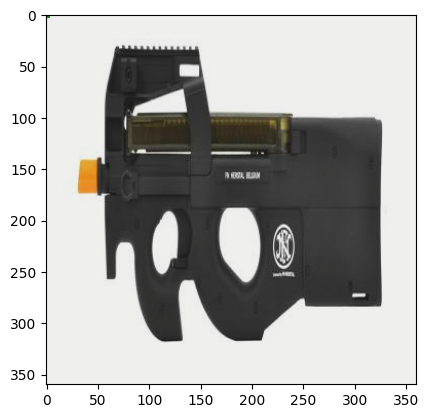

In [18]:
# Function to visualize an image with bounding boxes
def plot_image_with_boxes(image, pred_boxes, true_boxes=None):
    plt.imshow(image)
    # Draw predicted boxes
    for box in pred_boxes:
        plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, color='red', linewidth=2))
    # Draw ground truth boxes if available
    if true_boxes is not None:
        for box in true_boxes:
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, color='green', linewidth=2))
    plt.show()

# Get a batch of data from the test dataset
test_dataset_iter = iter(test_dataset)  # Create an iterator
batch = next(test_dataset_iter)  # Extract one batch

# Extract image and true bounding boxes from the batch
image = batch[1][0].numpy()  # Get the first image in the batch and convert to numpy
true_boxes = batch[1]['bbox_output'][0].numpy()  # Get the true bounding boxes for the first image

# Predict bounding boxes
pred_boxes = model.predict(image[np.newaxis, ...])[1][0]  # Predict bounding boxes and take the first prediction

# Plot the image with predicted and true bounding boxes
plot_image_with_boxes(image, [pred_boxes], [true_boxes])


1/1 [==============================] - 0s 245ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20929751..1.0868285].


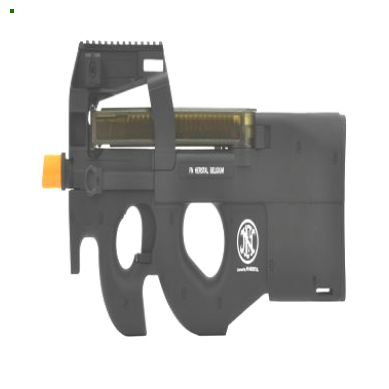

1/1 [==============================] - 0s 274ms/step


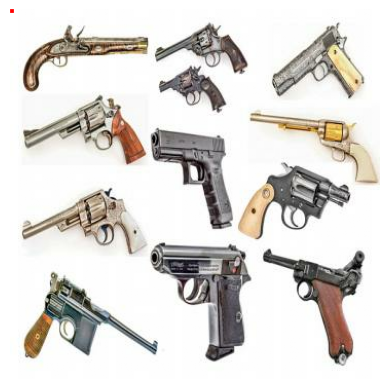

1/1 [==============================] - 0s 252ms/step


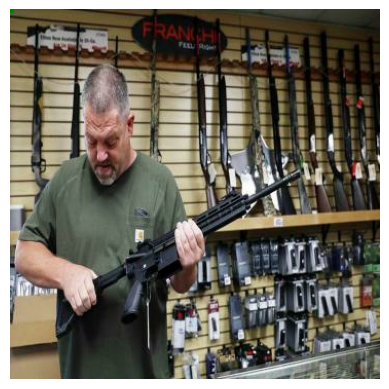

1/1 [==============================] - 0s 235ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039864704..0.8221616].


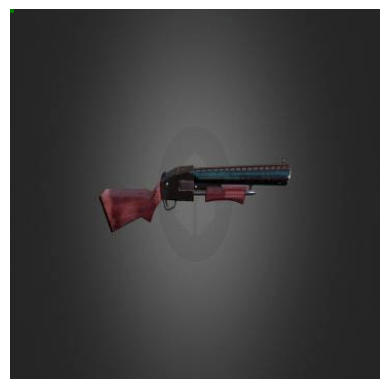

1/1 [==============================] - 0s 236ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06429213..1.0712738].


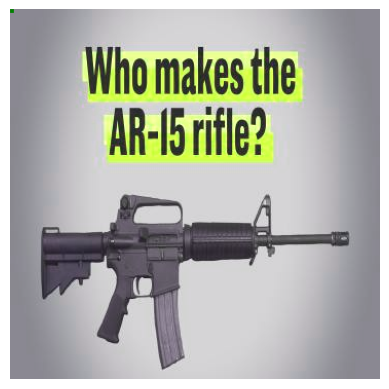

In [19]:
# Function to visualize an image with bounding boxes
def plot_image_with_boxes(image, pred_boxes, true_boxes=None):
    plt.imshow(image)
    for box in pred_boxes:
        plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, color='red', linewidth=2))
    if true_boxes is not None:
        for box in true_boxes:
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, color='green', linewidth=2))
    plt.axis('off')
    plt.show()

# Loop through a batch of images from the test dataset
num_images = 5  # Set the number of images you want to visualize
for i, batch in enumerate(test_dataset.take(num_images)):
    # Extract image and true bounding boxes
    image = batch[0][0].numpy()
    true_boxes = batch[1]['bbox_output'][0].numpy()
    
    # Predict bounding boxes
    pred_boxes = model.predict(image[np.newaxis, ...])[1][0]
    
    # Plot the image with predicted and true bounding boxes
    plot_image_with_boxes(image, [pred_boxes], [true_boxes])
    
    if i >= num_images - 1:
        break  # Stop after displaying the desired number of images


1/1 [==============================] - 0s 209ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21608472..1.163023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039864704..0.8221616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12850395..0.821556].


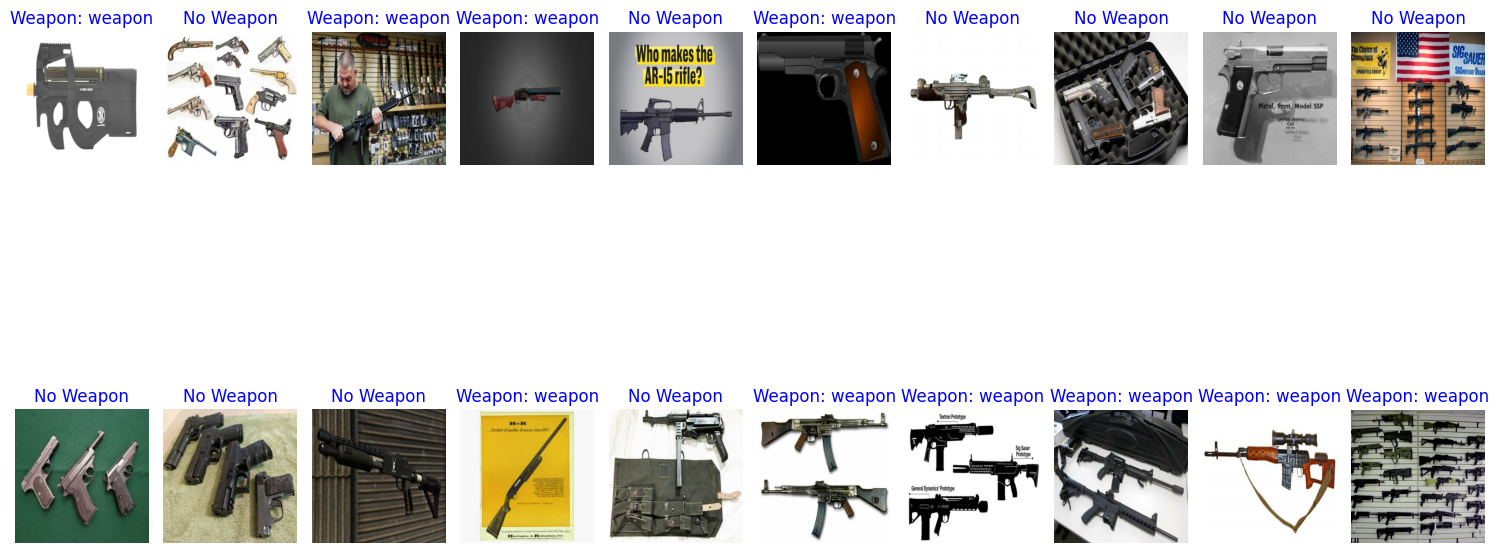

In [25]:

# Function to visualize an image with bounding boxes and labels
def plot_images_with_labels(images, pred_boxes, pred_labels, true_boxes=None, num_cols=3):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed
    
    plt.figure(figsize=(15, num_rows * 5))
    
    for i in range(num_images):
        image = images[i]
        pred_box = pred_boxes[i]
        pred_label = pred_labels[i]
        true_box = true_boxes[i] if true_boxes else None
        
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.imshow(image)
        
        # Predicted bounding box
        ax.add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
                                   fill=False, color='red', linewidth=2, label="Predicted"))
        
        # True bounding box, if provided
        if true_box is not None:
            ax.add_patch(plt.Rectangle((true_box[0], true_box[1]), true_box[2], true_box[3],
                                       fill=False, color='green', linewidth=2, label="Ground Truth"))
        
        # Set title to display the predicted label
        label_text = "Weapon: " + pred_label if pred_label != "no weapon" else "No Weapon"
        ax.set_title(label_text, color="blue", fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Loop through the test dataset and collect images, predicted boxes, and labels
images, pred_boxes, pred_labels, true_boxes = [], [], [], []
num_images = 20  # Number of images to display

for i, batch in enumerate(test_dataset.take(num_images)):
    image = batch[0][0].numpy()
    true_box = batch[1]['bbox_output'][0].numpy()
    
    # Get predictions
    class_pred, bbox_pred = model.predict(image[np.newaxis, ...])
    pred_class = class_pred.argmax(axis=1)[0]
    pred_label = "weapon" if pred_class > 0.4 else "no weapon"
    
    # Collect for display
    images.append(image)
    pred_boxes.append(bbox_pred[0])
    pred_labels.append(pred_label)
    true_boxes.append(true_box)
    
    if i >= num_images - 1:
        break

# Plot all images in a row with labels
plot_images_with_labels(images, pred_boxes, pred_labels, true_boxes, num_cols=10)
